Entrez la valeur de M pour M-QAM (ex: 4, 16, 64, 256):  256


Modulation choisie : 256-QAM → 8 bits par symbole


Voulez-vous utiliser le codage Gray ? (y/n) :  y
Entrez la position I du premier symbole :  2
Entrez la position Q du premier symbole :  2
Type de bruit ? (1: phase, 2: amplitude, 3: combiné) :  1
Nombre de versions bruitées à générer :  2


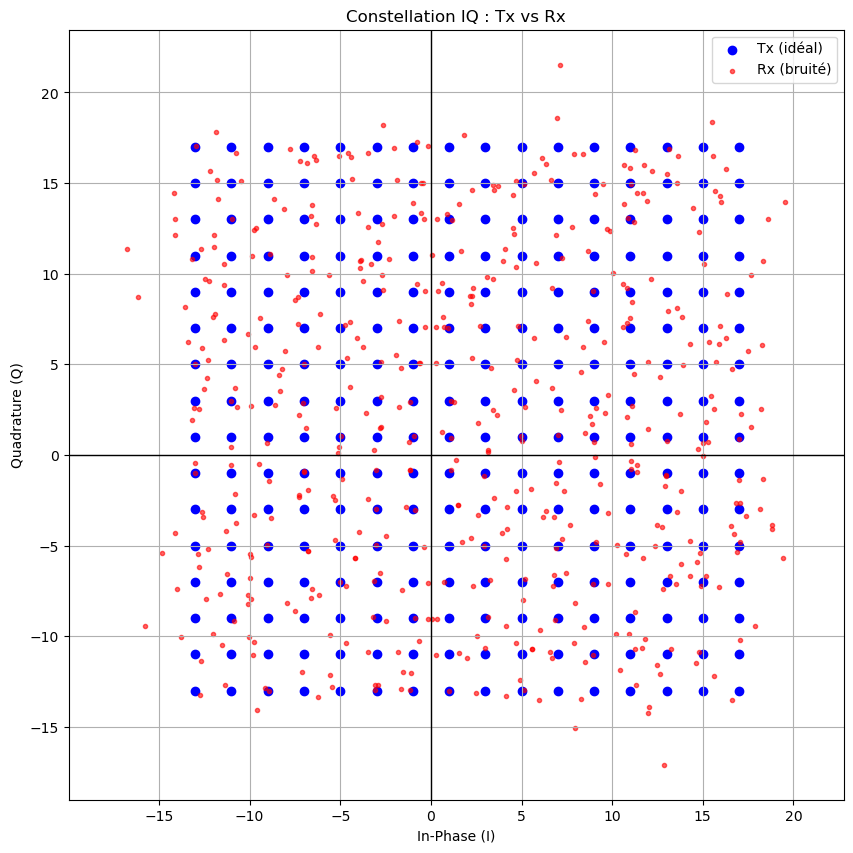


SNR calculé : 14.95 dB

Bit Error Rate (BER) : 0.436279

Image importée : (256, 256, 3)


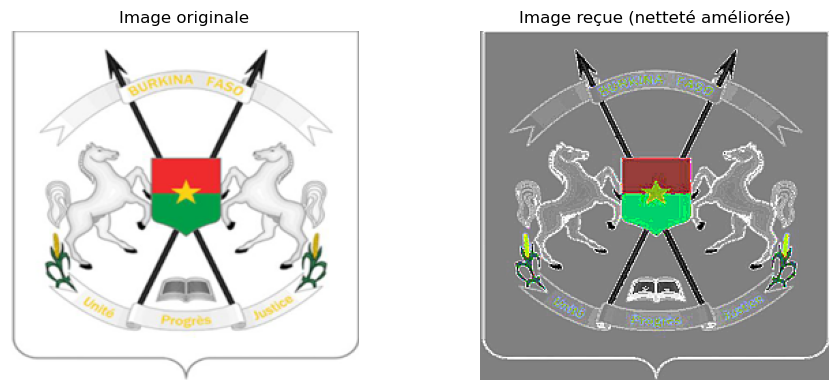

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tkinter import Tk, filedialog
from PIL import Image, ImageEnhance

# --- Étape 1 : Choix utilisateur pour M-QAM ---
def get_mqam_parameters():
    M = int(input("Entrez la valeur de M pour M-QAM (ex: 4, 16, 64, 256): "))
    if not (M != 0 and ((M & (M - 1)) == 0)):
        raise ValueError("M doit être une puissance de 2 (2, 4, 8, 16, ...)")
    k = int(np.log2(M))
    print(f"Modulation choisie : {M}-QAM → {k} bits par symbole")

    gray_choice = input("Voulez-vous utiliser le codage Gray ? (y/n) : ").strip().lower()
    use_gray = gray_choice == 'y'

    return M, k, use_gray

# --- Codage Gray ---
def generate_gray_code(n):
    if n == 1:
        return ['0', '1']
    prev_gray = generate_gray_code(n - 1)
    return ['0' + code for code in prev_gray] + ['1' + code for code in reversed(prev_gray)]

# --- Table constellation QAM ---
def generate_qam_constellation(M, k, use_gray):
    side = int(np.sqrt(M))
    if side**2 != M:
        raise ValueError("M-QAM doit être un carré parfait (ex: 4, 16, 64...)")

    levels = np.arange(-side + 1, side, 2)
    iq_points = [(i, q) for q in reversed(levels) for i in levels]
    decimals = np.arange(M)
    bits_bin = [format(d, f'0{k}b') for d in decimals]

    if use_gray:
        gray_list = generate_gray_code(k)
        bits = gray_list
    else:
        bits = bits_bin

    table = []
    for idx in range(M):
        bits_str = bits[idx]
        dec = int(bits_bin[idx], 2)
        i, q = iq_points[idx]
        energy = i**2 + q**2
        amplitude = np.sqrt(energy)
        phase = np.arctan2(q, i)
        table.append({
            'Symbole': f"S{idx}",
            'Bits': bits_str,
            'Décimal': dec,
            'I': i,
            'Q': q,
            'Amplitude': round(amplitude, 2),
            'Énergie (V²)': round(energy, 2),
            'Phase (rad)': round(phase, 4)
        })

    return pd.DataFrame(table)

# --- Génération des points IQ ---
def generate_custom_qam_constellation(M, I_0, Q_0):
    side = int(np.sqrt(M))
    levels = np.arange(side) * 2 - (side - 1)
    iq_points = [(i + I_0, q + Q_0) for q in reversed(levels) for i in levels]
    return np.array(iq_points)

# --- Bruit configurable ---
def add_noise(points, noise_type=1, num_noisy_points=1):
    noisy_all = []
    for _ in range(num_noisy_points):
        if noise_type == 1:
            noise_phase = np.random.randn(len(points)) * (np.pi / 18)
            noisy = points * np.exp(1j * noise_phase)
        elif noise_type == 2:
            amp_noise = np.random.randn(len(points)) * 0.2
            amplitude = np.abs(points) + amp_noise
            phase_angles = np.angle(points)
            noisy = amplitude * np.exp(1j * phase_angles)
        elif noise_type == 3:
            noise_phase = np.random.randn(len(points)) * (np.pi / 18)
            amp_noise = np.random.randn(len(points)) * 0.2
            amplitude = np.abs(points) + amp_noise
            noisy = amplitude * np.exp(1j * (np.angle(points) + noise_phase))
        else:
            raise ValueError("noise_type doit être 1 (phase), 2 (amplitude), ou 3 (combiné).")
        noisy_all.append(noisy)
    return np.concatenate(noisy_all)

# --- SNR ---
def calculate_snr(signal, noisy_signal):
    noise = noisy_signal - np.tile(signal, int(len(noisy_signal) / len(signal)))
    signal_power = np.mean(np.abs(signal)**2)
    noise_power = np.mean(np.abs(noise)**2)
    return 10 * np.log10(signal_power / noise_power)

# --- BER ---
def calculate_ber(original_bits, received_bits):
    errors = np.sum(original_bits != received_bits)
    return errors / len(original_bits)

# --- Détection de symboles ---
def detect_symbols(rx_points, ref_points, ref_bits):
    detected_bits = []
    for pt in rx_points:
        distances = np.abs(ref_points - pt)
        idx = np.argmin(distances)
        detected_bits.append(list(map(int, list(ref_bits[idx]))))
    return np.array(detected_bits)

# --- Visualisation constellation ---
def visualiser_constellation_comparée(tx_points, rx_points):
    plt.figure(figsize=(10, 10))
    plt.scatter(tx_points.real, tx_points.imag, color='blue', marker='o', label='Tx (idéal)')
    plt.scatter(rx_points.real, rx_points.imag, color='red', marker='.', alpha=0.6, label='Rx (bruité)')
    plt.title("Constellation IQ : Tx vs Rx")
    plt.xlabel("In-Phase (I)")
    plt.ylabel("Quadrature (Q)")
    plt.grid(True)
    plt.axhline(0, color='black', linewidth=1)
    plt.axvline(0, color='black', linewidth=1)
    plt.legend()
    plt.axis('equal')
    plt.show()

# --- Importer une image couleur ---
def importer_image_rgb():
    root = Tk()
    root.withdraw()
    file_path = filedialog.askopenfilename(
        title="Sélectionner une image à transmettre",
        filetypes=[("Image files", "*.png *.jpg *.jpeg *.bmp")]
    )
    if not file_path:
        raise FileNotFoundError("Aucune image sélectionnée.")
    image = Image.open(file_path).convert("RGB")
    image = image.resize((256, 256))
    return np.array(image)

# --- Transmission image avec filtre de netteté ---
def transmettre_image_rgb():
    img_array_rgb = importer_image_rgb()
    print(f"\nImage importée : {img_array_rgb.shape}")
    
    img_r, img_g, img_b = img_array_rgb[:, :, 0], img_array_rgb[:, :, 1], img_array_rgb[:, :, 2]

    def convert_channel_to_bits(channel):
        flattened = channel.flatten()
        img_bits = np.unpackbits(flattened.astype(np.uint8))
        adjusted_length = len(img_bits) - (len(img_bits) % k)
        return img_bits[:adjusted_length]
    
    img_r_bits = convert_channel_to_bits(img_r)
    img_g_bits = convert_channel_to_bits(img_g)
    img_b_bits = convert_channel_to_bits(img_b)

    def encode_channel_bits(bits):
        img_symbols = bits.reshape(-1, k)
        img_dec = np.array([int("".join(map(str, b)), 2) for b in img_symbols])
        return iq_points_complex[img_dec]
    
    tx_r = encode_channel_bits(img_r_bits)
    tx_g = encode_channel_bits(img_g_bits)
    tx_b = encode_channel_bits(img_b_bits)

    snr_db_image = 60
    snr_linear_img = 10**(snr_db_image / 10)
    noise_power_img = np.mean(np.abs(iq_points_complex)**2) / snr_linear_img
    noise_img = np.sqrt(noise_power_img / 2) * (np.random.randn(len(tx_r)) + 1j * np.random.randn(len(tx_r)))

    rx_r = tx_r + noise_img
    rx_g = tx_g + noise_img
    rx_b = tx_b + noise_img

    def detect_channel_bits(rx_channel):
        return detect_symbols(rx_channel, iq_points_complex, constellation_table['Bits'].values).flatten()

    rx_r_bits = detect_channel_bits(rx_r)
    rx_g_bits = detect_channel_bits(rx_g)
    rx_b_bits = detect_channel_bits(rx_b)

    def reconstruct_image(bits):
        reconstructed = np.packbits(bits)
        return reconstructed.reshape(img_array_rgb.shape[:2])

    img_r_recu = reconstruct_image(rx_r_bits)
    img_g_recu = reconstruct_image(rx_g_bits)
    img_b_recu = reconstruct_image(rx_b_bits)

    img_recu_rgb = np.stack((img_r_recu, img_g_recu, img_b_recu), axis=-1)

    # --- Appliquer un filtre de netteté ---
    img_recu_pil = Image.fromarray(img_recu_rgb)
    enhancer = ImageEnhance.Sharpness(img_recu_pil)
    img_recu_nette = enhancer.enhance(2.0)  # Tu peux changer 2.0 par une valeur plus grande si tu veux plus net

    # --- Affichage ---
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_array_rgb)
    plt.title("Image originale")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img_recu_nette)
    plt.title("Image reçue ")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# --- MAIN ---
M, k, use_gray = get_mqam_parameters()
I_0 = float(input("Entrez la position I du premier symbole : "))
Q_0 = float(input("Entrez la position Q du premier symbole : "))
iq_points = generate_custom_qam_constellation(M, I_0, Q_0)
iq_points_complex = iq_points[:, 0] + 1j * iq_points[:, 1]

noise_type = int(input("Type de bruit ? (1: phase, 2: amplitude, 3: combiné) : "))
num_noisy = int(input("Nombre de versions bruitées à générer : "))
noisy_iq_points = add_noise(iq_points_complex, noise_type=noise_type, num_noisy_points=num_noisy)

visualiser_constellation_comparée(iq_points_complex, noisy_iq_points)

calculated_snr = calculate_snr(iq_points_complex, noisy_iq_points)
print(f"\nSNR calculé : {calculated_snr:.2f} dB")

constellation_table = generate_qam_constellation(M, k, use_gray)
original_bits = np.array([list(map(int, list(format(i, f'0{k}b')))) for i in range(M)])
original_bits = np.tile(original_bits, (num_noisy, 1))

received_bits = detect_symbols(noisy_iq_points, iq_points_complex, constellation_table['Bits'].values)
if original_bits.shape == received_bits.shape:
    ber = calculate_ber(original_bits.flatten(), received_bits.flatten())
    print(f"\nBit Error Rate (BER) : {ber:.6f}")

# Transmission d'image avec netteté
transmettre_image_rgb()
